In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import networkx as nx
import ast

from nanonets import Simulation, NanoparticleTunneling
from nanonets.utils import extract_harmonic_features, BLUE_COLOR, RED_COLOR, get_displacement_currents, get_SET_TAU_F0
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.signal import correlate2d, correlate
from scipy.optimize import curve_fit
from scipy.linalg import eig
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


plt.style.use(["science","bright","grid"])
# PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq_size/"
# PATH = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/amp_freq_size/"
PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/amp_freq_size/"

def get_lattice_electrode_cap_matrix(L: int):
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*8}
    sim  = Simulation(topo)
    return sim.get_electrode_capacitance_matrix()

def get_phase_lag(response_signal: np.ndarray, input_signal: np.ndarray) -> float:
    """
    Calculates the Phase Lag between a system response and the driving input 
    at the fundamental driving frequency.
    
    Formula: Phase = Angle(Response) - Angle(Input)
    
    Parameters:
    -----------
    response_signal : np.ndarray
        The output time series (e.g., spatially averaged potential or total current).
        Shape: (steps,)
    input_signal : np.ndarray
        The driving input time series (e.g., sine wave voltage).
        Shape: (steps,)
        
    Returns:
    --------
    phase_deg : float
        The phase shift in degrees.
        Range is normalized to [-180, 180]. 
        Negative values indicate the response 'lags' behind the input (Capacitive).
        Positive values indicate the response 'leads' the input (Inductive).
    """
    
    # 1. Apply Windowing (Optional but recommended to reduce spectral leakage)
    # If your signal is an exact integer number of periods, you can skip this.
    # Otherwise, a Hanning window helps.
    window = np.hanning(len(response_signal))
    resp_w = response_signal * window
    input_w = input_signal * window
    
    # 2. Compute FFT
    # We use rfft because the signals are real-valued
    fft_resp = np.fft.rfft(resp_w)
    fft_in = np.fft.rfft(input_w)
    
    # 3. Find the Fundamental Frequency Index
    # We assume the input is a dominant sine wave, so we just find the max peak.
    # We skip index 0 (DC component).
    idx_fund = np.argmax(np.abs(fft_in[1:])) + 1
    
    # 4. Extract Angles (Phases) at that index
    angle_resp = np.angle(fft_resp[idx_fund])
    angle_in = np.angle(fft_in[idx_fund])
    
    # 5. Calculate Difference
    phase_diff = angle_resp - angle_in
        
    # 7. Normalize to [-180, 180] range
    # This handles wrap-around (e.g., if result is -270, it becomes +90)
    phase_diff = (phase_diff + np.pi) % (2 * np.pi) - np.pi
    
    return phase_diff / np.pi

In [69]:
# PARAMETER
N_PARTICLES     = [3,9,13]
AMPLITUDE       = 0.1
AMPLITUDE_LIST  = [AMPLITUDE]
FREQ_LIST_MHZ   = [0.005,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,
                   10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.,266.,610.,1200.,2400.]
N_PERIODS       = 100
N_SKIP          = 80
SAMPLE_P_PERIOD = 40
N_ELECTRODES    = 8
N_NP            = 9
PLOT_SIZE_NORM  = Normalize(vmin=N_PARTICLES[0]**2, vmax=N_PARTICLES[-1]**2)
C_US            = {N : get_lattice_electrode_cap_matrix(N).T for N in N_PARTICLES}
TAU_SET, F0_SET = get_SET_TAU_F0()

### Simulation Data

In [3]:
dts         = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps     = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time        = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data        = {N : {freq : pd.read_csv(f"{PATH}Nx={N}_Ny={N}_Ne=8_{freq:.3f}_{AMPLITUDE:.3f}.csv") for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
states      = {N : {freq : pd.read_csv(f"{PATH}mean_state_Nx={N}_Ny={N}_Ne=8_{freq:.3f}_{AMPLITUDE:.3f}.csv") for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}

In [4]:
x   = {N : {freq : data[N][freq]['E0'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
y_t = {N : {freq : data[N][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
y_e = {N : {freq : data[N][freq]['Error'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
p   = {N : {freq : states[N][freq].iloc[:,8:].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
p_m = {N : {freq : np.mean(states[N][freq].iloc[:,8:].values, axis=1)[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
y_d = {N : {freq : get_displacement_currents(p[N][freq], C_US[N], dts[freq]) for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
y   = {N : {freq : y_t[N][freq]+y_d[N][freq] for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}

In [42]:
B       = 200
h0s_p   = {N : np.array([extract_harmonic_features(p_m[N][f0], n_vals=[1], mode='abs', pad_len=4096) for f0 in FREQ_LIST_MHZ]).flatten() for N in N_PARTICLES}
h0s_I   = {N : np.array([[extract_harmonic_features(y[N][f0]+np.random.normal(0, y_e[N][f0]/1.96), n_vals=[1], mode='abs', pad_len=4096) for _ in range(B)] for f0 in FREQ_LIST_MHZ]) for N in N_PARTICLES}
gain_p  = {N : 20*np.log10(h0s_p[N]/h0s_p[N][0]) for N in N_PARTICLES}
gain_I  = {N : 20*np.log10(h0s_I[N]/h0s_I[N][0]) for N in N_PARTICLES}

### Linear KCL

In [70]:
def get_matrices(L: int, N_e: int, load=True, short_range=False):

    sim = NanoparticleTunneling()
    sim.lattice_network(L, L)
    sim.add_electrodes_to_lattice_net([[(L-1)//2, 0],[0, 0],[L-1, 0],[0, (L-1)//2],[L-1, (L-1)//2],[0, L-1],[L-1, L-1],[(L-1)//2, L-1]])
    sim.init_nanoparticle_radius()
    sim.pack_lattice()
    sim.calc_capacitance_matrix(short_range=short_range)
    sim.calc_electrode_capacitance_matrix(short_range=short_range)
    sim.init_adv_indices()
    sim.init_junction_resistances()
    sim.build_conductance_matrix()

    # Conductance Matrix
    G     = sim.get_conductance_matrix()
    G_mat = G[:-N_e,:-N_e]
    G_u   = G[:-N_e,-N_e:]

    # Capacitance Matrix
    if load:
        if L > 7:
            C_mat = np.loadtxt(f"/mnt/c/Users/jonas/Desktop/phd/nanonets/scripts/capacitance_matrix/data/c_mat_{L}.csv")*1e-18
            C_u   = -1.0*np.abs(np.loadtxt(f"/mnt/c/Users/jonas/Desktop/phd/nanonets/scripts/capacitance_matrix/data/c_ele_{L}.csv").T)*1e-18
        else:
            C_mat = np.loadtxt(f"/mnt/c/Users/jonas/Desktop/phd/nanonets/scripts/capacitance_matrix/data_ref/c_mat_L={L}.csv")*1e-18
            C_u   = -1.0*np.abs(np.loadtxt(f"/mnt/c/Users/jonas/Desktop/phd/nanonets/scripts/capacitance_matrix/data_ref/c_ele_L={L}.csv").T)*1e-18
        
        # C_mat = np.loadtxt(f"/home/j/j_mens07/phd/data/capacitance_matrix/c_mat_{L}.csv")*1e-18
        # C_u   = -1.0*np.abs(np.loadtxt(f"/home/j/j_mens07/phd/data/capacitance_matrix/c_ele_{L}.csv").T)*1e-18
    else:
        C_mat = sim.get_capacitance_matrix()*1e-18
        C_u   = -1.0*np.abs(sim.get_electrode_capacitance_matrix().T)*1e-18

    return G_mat, G_u, C_mat, C_u

def get_potential_phasor(G_mat, G_u, C_mat, C_u, U, omega):

    Y       = G_mat + C_mat*omega*1j
    I_ext   = -(G_u + C_u*omega*1j)@U

    return np.linalg.solve(Y, I_ext)

def get_current_phasor(G_mat, G_u, C_mat, C_u, U, omega):

    Y     = G_mat + C_mat*omega*1j
    I_ext = -(G_u + C_u*omega*1j)@U
    phi_phasor = np.linalg.solve(Y, I_ext)
    
    target_elec_idx     = -1
    y_coupling_vector   = G_u[:, target_elec_idx] + 1j * omega * C_u[:, target_elec_idx]

    I_out = -1.0 * np.dot(y_coupling_vector, phi_phasor.flatten())

    return I_out

In [108]:
L           = 7
FREQ_LIST   = np.logspace(-2,5,100)
nu_LIST     = FREQ_LIST / F0_SET

# Calculate Phasor
for load,short in zip((True,False,False),(False,False,True)):
    G_mat, G_u, C_mat, C_u  = get_matrices(L, 8, load=load, short_range=short)
    if load:
        C_mat = C_mat + np.eye(L**2,L**2)*4.33*1e-18
    U_phasor                = np.array([0.1,0,0,0,0,0,0,0])[:,np.newaxis]
    phi_phasor              = np.mean(np.array([get_potential_phasor(G_mat, G_u, C_mat, C_u, U_phasor, 2*np.pi*freq*1e6).flatten() for freq in FREQ_LIST]),axis=1)
    I_phasor                = np.array([get_current_phasor(G_mat, G_u, C_mat, C_u, U_phasor, 2*np.pi*freq*1e6).flatten() for freq in FREQ_LIST])
    eigenvals, eigenvecs    = eig(G_mat, C_mat)
    poles_rad_s             = np.sort(np.real(eigenvals)) / (2 * np.pi)
    nu_poles                = poles_rad_s*1e-6 / F0_SET
    coup_matrix             = -1.0*np.linalg.inv(C_mat)@C_u
    U, s, Vh                = np.linalg.svd(coup_matrix, full_matrices=True)

    if load:
        gain_I_true = 20*np.log10(np.abs(I_phasor / I_phasor[0])).flatten()
        gain_p_true = 20*np.log10(np.abs(phi_phasor / phi_phasor[0])).flatten()
        C_mat_true  = C_mat
        C_u_true    = C_u
        poles_true  = nu_poles
        coup_true   = coup_matrix
        svd_true    = s
    else:
        if short:
            gain_I_short = 20*np.log10(np.abs(I_phasor / I_phasor[0])).flatten()
            gain_p_short = 20*np.log10(np.abs(phi_phasor / phi_phasor[0])).flatten()
            C_mat_short  = C_mat
            C_u_short    = C_u
            poles_short  = nu_poles
            coup_short   = coup_matrix
            svd_short    = s
        else:
            gain_I_long = 20*np.log10(np.abs(I_phasor / I_phasor[0])).flatten()
            gain_p_long = 20*np.log10(np.abs(phi_phasor / phi_phasor[0])).flatten()
            C_mat_long  = C_mat
            C_u_long    = C_u
            poles_long  = nu_poles
            coup_long   = coup_matrix
            svd_long    = s

In [98]:
# np.round(C_u_true*1e18,2)

In [110]:
np.sum(np.round(C_mat_short*1e18,2),axis=1) + np.sum(np.round(C_u_short*1e18,2),axis=1)

array([4.33, 4.33, 4.33, 4.32, 4.33, 4.33, 4.33, 4.33, 4.32, 4.32, 4.32,
       4.32, 4.32, 4.33, 4.33, 4.32, 4.32, 4.32, 4.32, 4.32, 4.33, 4.32,
       4.32, 4.32, 4.32, 4.32, 4.32, 4.32, 4.33, 4.32, 4.32, 4.32, 4.32,
       4.32, 4.33, 4.33, 4.32, 4.32, 4.32, 4.32, 4.32, 4.33, 4.33, 4.33,
       4.33, 4.32, 4.33, 4.33, 4.33])

In [109]:
np.sum(np.round(C_mat_true*1e18,2),axis=1) + np.sum(np.round(C_u_true*1e18,2),axis=1)

array([4.39, 4.35, 4.35, 4.38, 4.35, 4.35, 4.39, 4.35, 4.36, 4.38, 4.39,
       4.38, 4.36, 4.35, 4.35, 4.38, 4.39, 4.33, 4.39, 4.38, 4.35, 4.38,
       4.39, 4.33, 4.3 , 4.33, 4.39, 4.38, 4.35, 4.38, 4.39, 4.33, 4.39,
       4.38, 4.35, 4.35, 4.36, 4.38, 4.39, 4.38, 4.36, 4.35, 4.39, 4.35,
       4.35, 4.38, 4.35, 4.35, 4.39])

### Linear Algebra

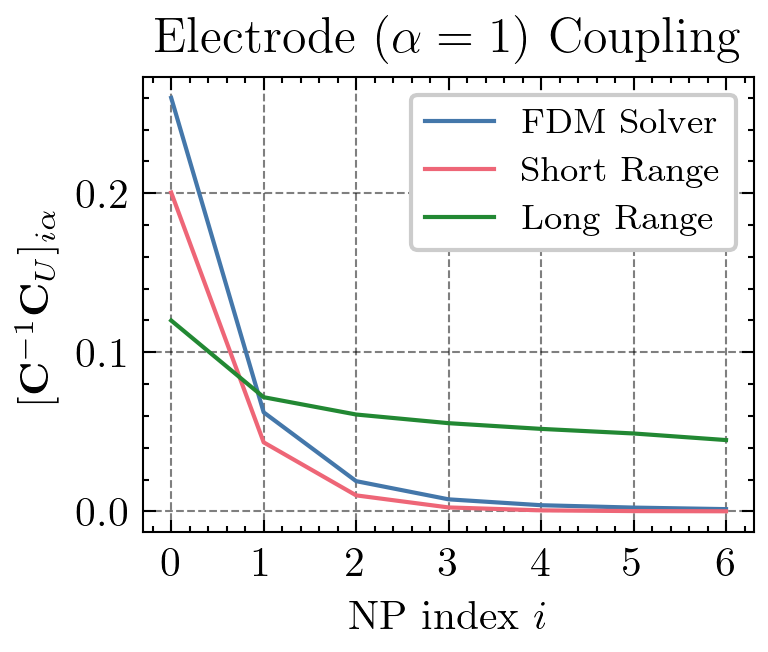

In [114]:
idx_on_line = [L//2 + n*L for n in range(L)]
fig, ax     = plt.subplots(dpi=300)
w, h        = fig.get_size_inches()
scale       = 0.75
fig.set_size_inches(w * scale, h * scale)

_   = ax.plot(coup_true[idx_on_line,0], label='FDM Solver')
_   = ax.plot(coup_short[idx_on_line,0], label='Short Range')
_   = ax.plot(coup_long[idx_on_line,0], label='Long Range')
_   = ax.set_xticks(np.arange(L))
# _   = ax.set_yscale('log')
_   = ax.set_xlabel("NP index $i$")
_   = ax.set_ylabel("$[\mathbf{C}^{-1}\mathbf{C}_U]_{i\\alpha}$")
_   = ax.set_title("Electrode ($\\alpha=1$) Coupling")
_   = ax.legend(fontsize='small')

# fig.savefig(f"plots/pdf/Coupling_Mat_FDM_Short_Long.pdf", transparent=False)
# fig.savefig(f"plots/svg/Coupling_Mat_FDM_Short_Long.svg", transparent=True)
# fig.savefig(f"plots/png/Coupling_Mat_FDM_Short_Long.png", transparent=False)

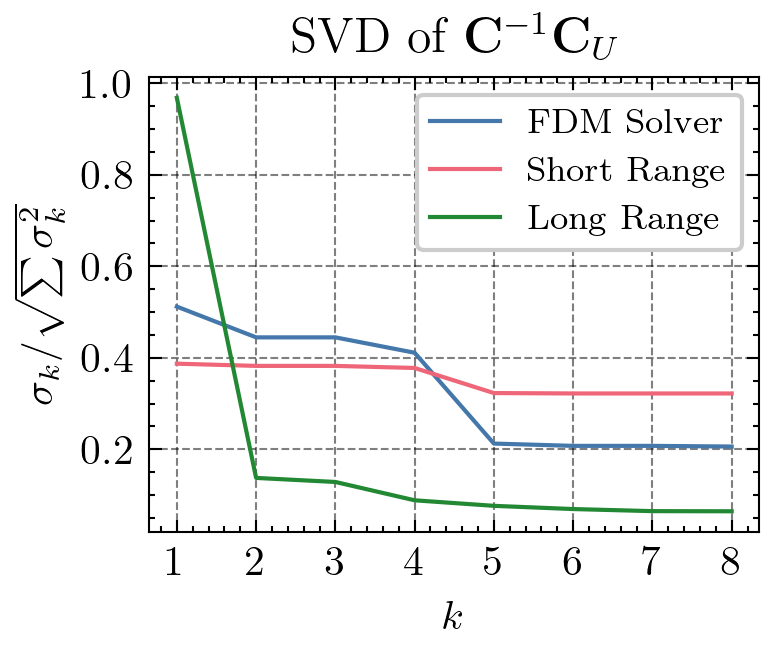

In [112]:
idx_on_line = [L//2 + n*L for n in range(L)]
fig, ax     = plt.subplots(dpi=300)
w, h        = fig.get_size_inches()
scale       = 0.75
fig.set_size_inches(w * scale, h * scale)

_   = ax.plot(np.arange(1,9),svd_true/np.sqrt(np.sum(svd_true**2)), label='FDM Solver')
_   = ax.plot(np.arange(1,9), svd_short/np.sqrt(np.sum(svd_short**2)), label='Short Range')
_   = ax.plot(np.arange(1,9), svd_long/np.sqrt(np.sum(svd_long**2)), label='Long Range')
_   = ax.set_xticks(np.arange(1,9))
# _   = ax.set_yscale('log')
_   = ax.set_xlabel("$k$")
_   = ax.set_ylabel("$\sigma_k / \\sqrt{\sum\sigma_k^2}$")
_   = ax.set_title("SVD of $\mathbf{C}^{-1}\mathbf{C}_U$")
_   = ax.legend(fontsize='small', loc='upper right')

fig.savefig(f"plots/pdf/SVD_FDM_Short_Long.pdf", transparent=False)
fig.savefig(f"plots/svg/SVD_FDM_Short_Long.svg", transparent=True)
fig.savefig(f"plots/png/SVD_FDM_Short_Long.png", transparent=False)

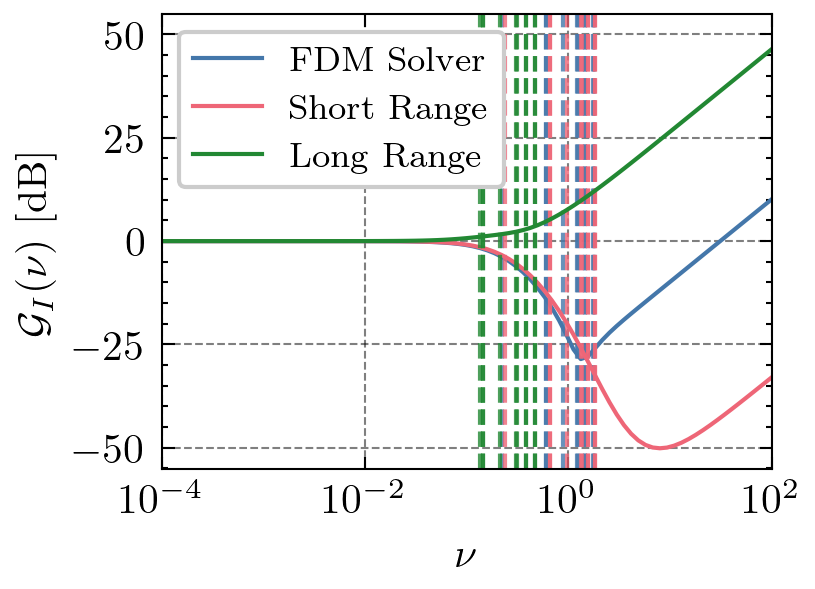

In [115]:
fig, ax     = plt.subplots(dpi=300)
w, h        = fig.get_size_inches()
scale       = 0.75
fig.set_size_inches(w * scale, h * scale)

# FDM Solver
pp      = ax.plot(nu_LIST, gain_I_true, label='FDM Solver')
for rate in poles_true[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Short Range
pp      = ax.plot(nu_LIST, gain_I_short, label='Short Range')
for rate in poles_short[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Long Range
pp      = ax.plot(nu_LIST, gain_I_long, label='Long Range')
for rate in poles_long[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Params
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_xlim(1e-4, 1e2)
_ = ax.set_ylabel("$\mathcal{G}_I(\\nu)$ [dB]")
_ = ax.legend(fontsize='small')


# fig.savefig(f"plots/pdf/KCL_gain_I_FDM_Short_Long.pdf", transparent=False)
# fig.savefig(f"plots/svg/KCL_gain_I_FDM_Short_Long.svg", transparent=True)
# fig.savefig(f"plots/png/KCL_gain_I_FDM_Short_Long.png", transparent=False)

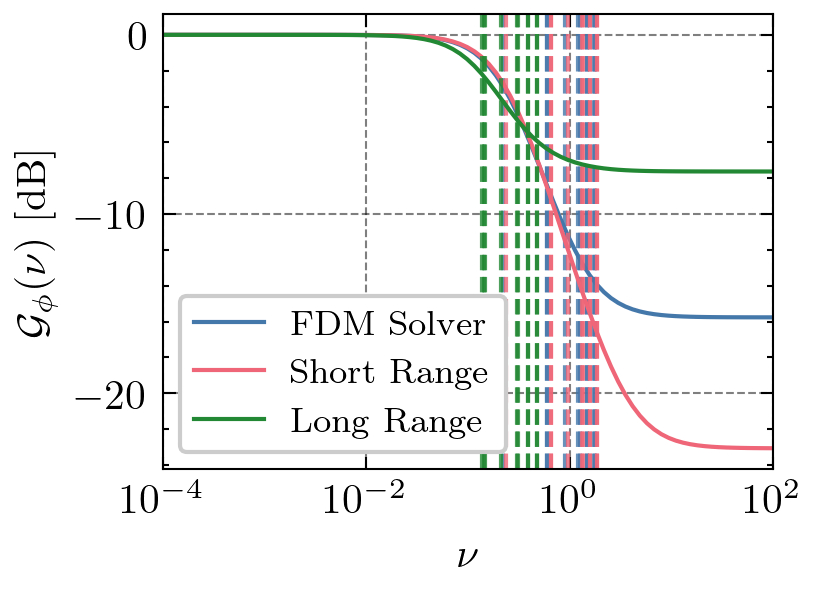

In [116]:
fig, ax     = plt.subplots(dpi=300)
w, h        = fig.get_size_inches()
scale       = 0.75
fig.set_size_inches(w * scale, h * scale)

# FDM Solver
pp      = ax.plot(nu_LIST, gain_p_true, label='FDM Solver')
for rate in poles_true[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Short Range
pp      = ax.plot(nu_LIST, gain_p_short, label='Short Range')
for rate in poles_short[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Long Range
pp      = ax.plot(nu_LIST, gain_p_long, label='Long Range')
for rate in poles_long[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Params
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_xlim(1e-4, 1e2)
_ = ax.set_ylabel("$\mathcal{G}_\\phi(\\nu)$ [dB]")
_ = ax.legend(fontsize='small')


# fig.savefig(f"plots/pdf/KCL_gain_phi_FDM_Short_Long.pdf", transparent=False)
# fig.savefig(f"plots/svg/KCL_gain_phi_FDM_Short_Long.svg", transparent=True)
# fig.savefig(f"plots/png/KCL_gain_phi_FDM_Short_Long.png", transparent=False)

In [ ]:
gain_p_theory           = {}
gain_p_theory_new       = {}
gain_I_theory           = {}
gain_I_theory_new       = {}
for N in N_PARTICLES:
        U_phasor = np.array([0.02,0,0,0,0,0,0,0])[:,np.newaxis]

        phi_phasor = np.mean(np.array([get_potential_phasor(N, 2*np.pi*freq*1e6, U_phasor).flatten() for freq in FREQ_LIST_MHZ+[4800,9600]]),axis=1)
        gain_arg = np.abs(phi_phasor / phi_phasor[0])
        # gain_arg = np.abs(phi_phasor / h0s_p[N][0])
        gain_phi = 20*np.log10(gain_arg)
        gain_p_theory[N] = gain_phi

        phi_phasor = np.mean(np.array([get_potential_phasor_new(N, 2*np.pi*freq*1e6, U_phasor).flatten() for freq in FREQ_LIST_MHZ+[4800,9600]]),axis=1)
        gain_arg = np.abs(phi_phasor / phi_phasor[0])
        # gain_arg = np.abs(phi_phasor / h0s_p[N][0])
        gain_phi = 20*np.log10(gain_arg)
        gain_p_theory_new[N] = gain_phi

        I_phasor = np.array([get_current_phasor(N, 2*np.pi*freq*1e6, U_phasor).flatten() for freq in FREQ_LIST_MHZ+[4800,9600]])
        gain_arg = np.abs(I_phasor / I_phasor[0])
        # gain_cur = gain_arg
        gain_cur = 20*np.log10(gain_arg)
        gain_I_theory[N] = gain_cur

        I_phasor = np.array([get_current_phasor_new(N, 2*np.pi*freq*1e6, U_phasor).flatten() for freq in FREQ_LIST_MHZ+[4800,9600]])
        gain_arg = np.abs(I_phasor / I_phasor[0])
        # gain_cur = gain_arg
        gain_cur = 20*np.log10(gain_arg)
        gain_I_theory_new[N] = gain_cur

In [ ]:
def get_potential_phasor(L: int, omega: float, U_phasor: np.ndarray, N_e: int = 8):
    # Node Network Structure (Lattice of LxL) with N_E=8 Electrodes
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*N_e}
    sim  = Simulation(topo)
    sim.build_conductance_matrix()
 
    G     = sim.get_conductance_matrix()                                        # Full linear Conductance Matrix of shape (L*L+N_E,L*L+N_E)
    G_mat = G[:-N_e,:-N_e]                                                      # Node to Node Conductance
    G_u   = G[:-N_e,-N_e:]                                                      # Node to Electrode Conductance
    C_mat = sim.get_capacitance_matrix()*1e-18                                  # Node to Node Capacitance
    C_u   = -1.0*np.abs(sim.get_electrode_capacitance_matrix().T)*1e-18         # Node to Electrode Capacitance
    Y     = G_mat + C_mat*omega*1j                                              # Admittance
    I_ext = -(G_u + C_u*omega*1j)@U_phasor                                      # Injected Current
    return np.linalg.solve(Y, I_ext)

def get_potential_phasor_new(L: int, omega: float, U_phasor: np.ndarray, N_e: int = 8):
    # Node Network Structure (Lattice of LxL) with N_E=8 Electrodes
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*N_e}
    sim  = Simulation(topo)
    sim.build_conductance_matrix()
 
    G     = sim.get_conductance_matrix()                                        # Full linear Conductance Matrix of shape (L*L+N_E,L*L+N_E)
    G_mat = G[:-N_e,:-N_e]                                                      # Node to Node Conductance
    G_u   = G[:-N_e,-N_e:]                                                      # Node to Electrode Conductance
    C_mat = np.loadtxt(f"/home/j/j_mens07/phd/data/capacitance_matrix/c_mat_{L}.csv")*1e-18
    C_u   = -1.0*np.abs(np.loadtxt(f"/home/j/j_mens07/phd/data/capacitance_matrix/c_ele_{L}.csv").T)*1e-18
#     C_mat = sim.get_capacitance_matrix()*1e-18                                  # Node to Node Capacitance
#     C_u   = -1.0*np.abs(sim.get_electrode_capacitance_matrix().T)*1e-18         # Node to Electrode Capacitance
    Y     = G_mat + C_mat*omega*1j                                              # Admittance
    I_ext = -(G_u + C_u*omega*1j)@U_phasor                                      # Injected Current
    return np.linalg.solve(Y, I_ext)

def get_current_phasor(L: int, omega: float, U_phasor: np.ndarray, N_e: int = 8):
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*N_e}
    sim  = Simulation(topo)
    sim.build_conductance_matrix()
    G     = sim.get_conductance_matrix()
    G_mat = G[:-N_e,:-N_e]
    G_u   = G[:-N_e,-N_e:]
    C_mat = sim.get_capacitance_matrix()*1e-18
    C_u   = -1.0*np.abs(sim.get_electrode_capacitance_matrix().T)*1e-18
    Y     = G_mat + C_mat*omega*1j
    I_ext = -(G_u + C_u*omega*1j)@U_phasor
    phi_phasor = np.linalg.solve(Y, I_ext)
    
    target_elec_idx = -1
    y_coupling_vector = G_u[:, target_elec_idx] + 1j * omega * C_u[:, target_elec_idx]

    I_out = -1.0 * np.dot(y_coupling_vector, phi_phasor.flatten())

    return I_out

def get_current_phasor_new(L: int, omega: float, U_phasor: np.ndarray, N_e: int = 8):
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*N_e}
    sim  = Simulation(topo)
    sim.build_conductance_matrix()
    G     = sim.get_conductance_matrix()
    G_mat = G[:-N_e,:-N_e]
    G_u   = G[:-N_e,-N_e:]
    C_mat = np.loadtxt(f"/home/j/j_mens07/phd/data/capacitance_matrix/c_mat_{L}.csv")*1e-18
    C_u   = -1.0*np.abs(np.loadtxt(f"/home/j/j_mens07/phd/data/capacitance_matrix/c_ele_{L}.csv").T)*1e-18
    Y     = G_mat + C_mat*omega*1j
    I_ext = -(G_u + C_u*omega*1j)@U_phasor
    phi_phasor = np.linalg.solve(Y, I_ext)
    
    target_elec_idx = -1
    y_coupling_vector = G_u[:, target_elec_idx] + 1j * omega * C_u[:, target_elec_idx]

    I_out = -1.0 * np.dot(y_coupling_vector, phi_phasor.flatten())

    return I_out

def get_matrices(L: int, N_e: int = 8):
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*N_e}
    sim  = Simulation(topo)
    sim.build_conductance_matrix()
    G     = sim.get_conductance_matrix()
    G_mat = G[:-N_e,:-N_e]
    C_mat = sim.get_capacitance_matrix()*1e-18
#     Y     = G_mat + C_mat*omega*1j
    
    return G_mat, C_mat

In [35]:
gain_p_theory           = {}
gain_p_theory_new       = {}
gain_I_theory           = {}
gain_I_theory_new       = {}
for N in N_PARTICLES:
        U_phasor = np.array([0.02,0,0,0,0,0,0,0])[:,np.newaxis]

        phi_phasor = np.mean(np.array([get_potential_phasor(N, 2*np.pi*freq*1e6, U_phasor).flatten() for freq in FREQ_LIST_MHZ+[4800,9600]]),axis=1)
        gain_arg = np.abs(phi_phasor / phi_phasor[0])
        # gain_arg = np.abs(phi_phasor / h0s_p[N][0])
        gain_phi = 20*np.log10(gain_arg)
        gain_p_theory[N] = gain_phi

        phi_phasor = np.mean(np.array([get_potential_phasor_new(N, 2*np.pi*freq*1e6, U_phasor).flatten() for freq in FREQ_LIST_MHZ+[4800,9600]]),axis=1)
        gain_arg = np.abs(phi_phasor / phi_phasor[0])
        # gain_arg = np.abs(phi_phasor / h0s_p[N][0])
        gain_phi = 20*np.log10(gain_arg)
        gain_p_theory_new[N] = gain_phi

        I_phasor = np.array([get_current_phasor(N, 2*np.pi*freq*1e6, U_phasor).flatten() for freq in FREQ_LIST_MHZ+[4800,9600]])
        gain_arg = np.abs(I_phasor / I_phasor[0])
        # gain_cur = gain_arg
        gain_cur = 20*np.log10(gain_arg)
        gain_I_theory[N] = gain_cur

        I_phasor = np.array([get_current_phasor_new(N, 2*np.pi*freq*1e6, U_phasor).flatten() for freq in FREQ_LIST_MHZ+[4800,9600]])
        gain_arg = np.abs(I_phasor / I_phasor[0])
        # gain_cur = gain_arg
        gain_cur = 20*np.log10(gain_arg)
        gain_I_theory_new[N] = gain_cur

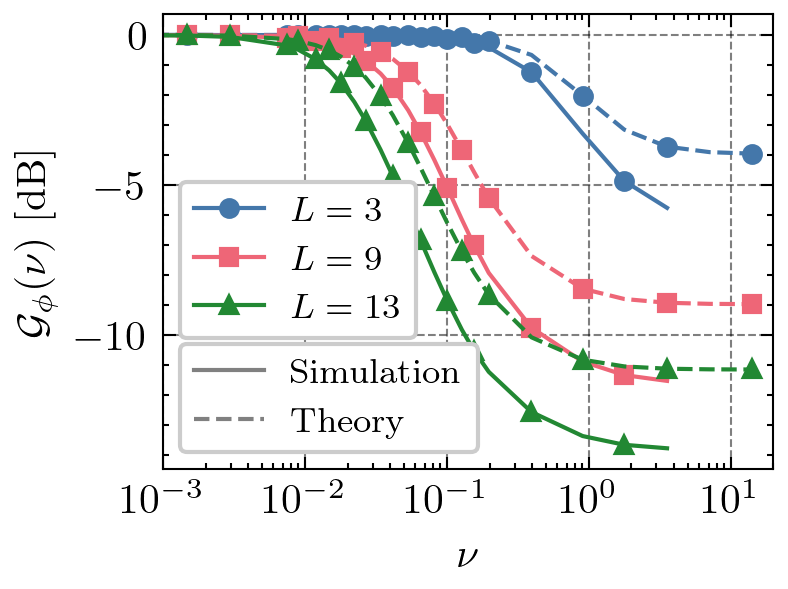

In [30]:
from matplotlib.lines import Line2D

fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
markers = ['o','s','^']
fig.set_size_inches(w * scale, h * scale)

# We'll store handles for the 'N' legend here
n_handles = []

for i, N in enumerate([3, 9, 13]):
    freqs = np.array(FREQ_LIST_MHZ) / F0_SET
    freqs_theory = np.array(FREQ_LIST_MHZ + [4800, 9600]) / F0_SET
    
    # 1. Simulation (Solid)
    line, = ax.plot(freqs, gain_p[N], marker=markers[i], ms=4, 
                    markevery=(1, 2), label=f'$L = {N}$')
    n_handles.append(line) # Save this for the first legend
    
    # 2. Theory (Dashed)
    ax.plot(freqs_theory, gain_p_theory[N], color=line.get_color(), 
            ls='--', marker=markers[i], ms=4, markevery=2)

# --- Legend 1: System Size (N) ---
# We use the handles we collected in the loop
leg1 = ax.legend(handles=n_handles, loc='lower left', fontsize='small', bbox_to_anchor=(0,0.25))
ax.add_artist(leg1) # This is the magic trick to keep the first legend from being deleted

# --- Legend 2: Simulation vs Theory ---
# We create "Proxy Artists" that only define the line style
style_handles = [
    Line2D([0], [0], color='gray', ls='-', label='Simulation'),
    Line2D([0], [0], color='gray', ls='--', label='Theory')
]
leg2 = ax.legend(handles=style_handles, loc='lower left', fontsize='small')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_xlim(1e-3, 2e1)
_ = ax.set_ylabel("$\mathcal{G}_\phi(\\nu)$ [dB]")

fig.savefig(f"plots/pdf/pot_f0_gain_theory_vs_sim.pdf", transparent=False)
fig.savefig(f"plots/svg/pot_f0_gain_theory_vs_sim.svg", transparent=True)
fig.savefig(f"plots/png/pot_f0_gain_theory_vs_sim.png", transparent=False)

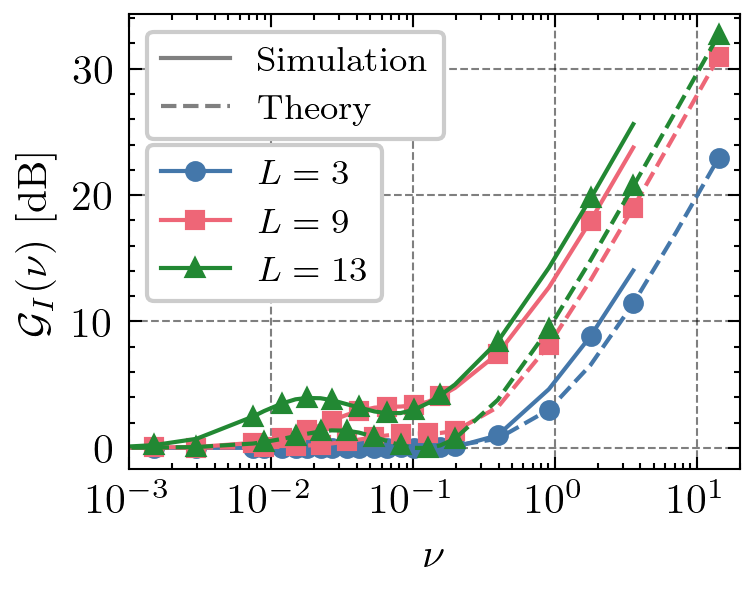

In [31]:
from matplotlib.lines import Line2D

fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
markers = ['o','s','^']
fig.set_size_inches(w * scale, h * scale)

# We'll store handles for the 'N' legend here
n_handles = []

for i, N in enumerate([3, 9, 13]):
    freqs = np.array(FREQ_LIST_MHZ) / F0_SET
    freqs_theory = np.array(FREQ_LIST_MHZ + [4800, 9600]) / F0_SET
    
    # 1. Simulation (Solid)
    line, = ax.plot(freqs, np.mean(gain_I[N],axis=1), marker=markers[i], ms=4, 
                    markevery=(1, 2), label=f'$L = {N}$')
    n_handles.append(line) # Save this for the first legend
    
    # 2. Theory (Dashed)
    ax.plot(freqs_theory, gain_I_theory[N], color=line.get_color(), 
            ls='--', marker=markers[i], ms=4, markevery=2)

# --- Legend 1: System Size (N) ---
# We use the handles we collected in the loop
leg1 = ax.legend(handles=n_handles, loc='upper left', bbox_to_anchor=(0,0.75), fontsize='small')
ax.add_artist(leg1) # This is the magic trick to keep the first legend from being deleted

# --- Legend 2: Simulation vs Theory ---
# We create "Proxy Artists" that only define the line style
style_handles = [
    Line2D([0], [0], color='gray', ls='-', label='Simulation'),
    Line2D([0], [0], color='gray', ls='--', label='Theory')
]
leg2 = ax.legend(handles=style_handles, loc='upper left', fontsize='small')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_xlim(1e-3, 2e1)
_ = ax.set_ylabel("$\mathcal{G}_I(\\nu)$ [dB]")

fig.savefig(f"plots/pdf/I_f0_gain_theory_vs_sim.pdf", transparent=False)
fig.savefig(f"plots/svg/I_f0_gain_theory_vs_sim.svg", transparent=True)
fig.savefig(f"plots/png/I_f0_gain_theory_vs_sim.png", transparent=False)

In [38]:
from scipy import linalg

L = 9

g_mat, c_mat = get_matrices(L)
eigenvalues, eigenvectors = linalg.eig(g_mat, c_mat)

rates_rad_s = np.sort(np.real(eigenvalues))
rates_rad_s = rates_rad_s[rates_rad_s > 0] # Remove any numerical noise near 0

# 3. Convert to Linear Frequency [Hz]
freqs_hz = rates_rad_s / (2 * np.pi)

# 4. Normalize to nu
# Ensure f_SET is in Hz (e.g., if 100 MHz, use 100e6)
# If your f_SET variable is already in Hz, just use it.
nu_eigen = freqs_hz*1e-6 / F0_SET

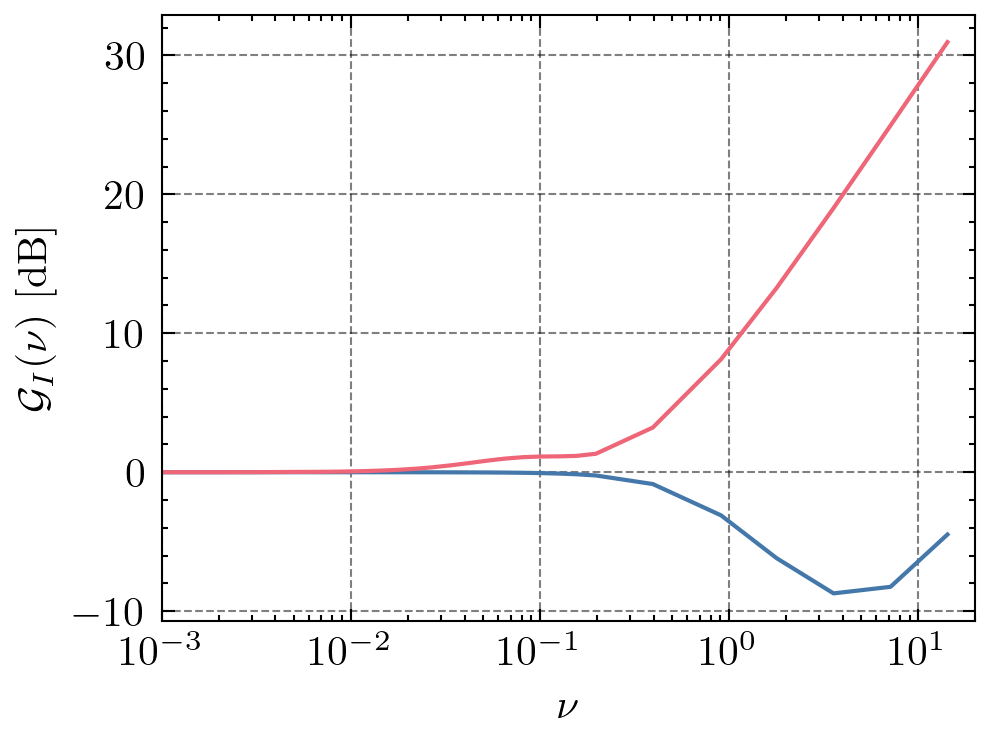

In [41]:
fig, ax = plt.subplots(dpi=300)
ax.plot(freqs_theory, gain_I_theory_new[L])
ax.plot(freqs_theory, gain_I_theory[L])
# for rate in nu_eigen:
#     plt.axvline(x=rate, color='k', linestyle='--', alpha=0.3)
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_xlim(1e-3, 2e1)
_ = ax.set_ylabel("$\mathcal{G}_I(\\nu)$ [dB]")


fig.savefig(f"plots/pdf/I_theory_gain_eigen.pdf", transparent=False)
fig.savefig(f"plots/svg/I_theory_gain_eigen.svg", transparent=True)
fig.savefig(f"plots/png/I_theory_gain_eigen.png", transparent=False)

### Phase

In [40]:
phase_s     = {N : [get_phase_lag(p_m[N][freq],x[N][freq]) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
phase_I     = {N : [get_phase_lag(y[N][freq],x[N][freq]) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
phase_I_t   = {N : [get_phase_lag(y_t[N][freq],x[N][freq]) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
phase_I_d   = {N : [get_phase_lag(y_d[N][freq],x[N][freq]) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}